In [1]:
import pandas as pd
import os
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [2]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

In [3]:
path_to_annotations = "/videos/mpi_data/2Itzik/dyadic_communication/annotations.csv"
df_raw = pd.read_csv(path_to_annotations)

In [4]:
# Recode shrg as shrai 
# Rename hands/arms as hands_arms
df_raw['label'] = df_raw['label'].replace('shrg', 'shrai')
df_raw['tier'] = df_raw['tier'].replace('hands/arms', 'hands_arms')

In [5]:
combinations_df = df_raw.groupby(['tier', 'label']).size().reset_index(name='count')
combinations_df

,tier,label,count
0,fubo,readj,9
1,hands_arms,fidg,33
2,hands_arms,htfa,10
3,hands_arms,hthd,3
4,head,hmov,47
5,head,hnod,217
6,head,hshk,51
7,lobo,fmov,234
8,lobo,lgcr,2
9,lobo,lgucr,2


In [6]:
feature_names = df_raw['label'].unique()
tier_names = df_raw['tier'].unique()

In [153]:
# Create a new column indicating the presence of a label
df_raw['label_presence'] = 1

# Pivot the table
reshaped_df = df_raw.groupby(['begin', 'end', 'seat', 'label'])['label_presence'].max().unstack(level=['label'], fill_value=0)

# Reset index to make 'begin', 'end' as columns
reshaped_df = reshaped_df.reset_index()

# Add this line after reshaped_df = reshaped_df.reset_index()
reshaped_df.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in reshaped_df.columns]

# Remove training _
reshaped_df.columns = [col[:-1] if col.endswith('_') else col for col in reshaped_df.columns]

# Remove end time and make begin the index
reshaped_df = reshaped_df.drop('end', axis=1).set_index(['begin','seat'])
# reshaped_df.head()

In [169]:
# add chagnes to the labels 
# 1. merge htfa into hthd
reshaped_df['htfa'] = reshaped_df['htfa'] | reshaped_df['hthd']
reshaped_df.drop(columns='hthd', inplace=True)  # Drop 'hthd'

# 2. remove lgcr and lgucr
reshaped_df.drop(columns='lgcr', inplace=True)  # Drop 'hthd'
reshaped_df.drop(columns='lgucr', inplace=True)  # Drop 'hthd'

#3. add to hmov all classes of head movment - hnod, hshk
reshaped_df['hmov'] = reshaped_df['hnod'] | reshaped_df['hshk'] | reshaped_df['hmov']

#4. add to readj all readjustments - blean, flean
reshaped_df['readj'] = reshaped_df['readj'] | reshaped_df['blean'] | reshaped_df['flean']

feature_names = reshaped_df.columns

In [210]:
feature_names = reshaped_df.columns

In [170]:
# # Pivot the table
# reshaped_df = df_raw.groupby(['begin', 'end', 'seat', 'tier'])['label_presence'].max().unstack(level=['tier'], fill_value=0)

# # Reset index to make 'begin', 'end' as columns
# reshaped_df = reshaped_df.reset_index()

# # Add this line after reshaped_df = reshaped_df.reset_index()
# reshaped_df.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in reshaped_df.columns]

# # Remove training _
# reshaped_df.columns = [col[:-1] if col.endswith('_') else col for col in reshaped_df.columns]

# # Remove end time and make begin the index
# reshaped_df = reshaped_df.drop('end', axis=1).set_index(['begin','seat'])
# reshaped_df.head()

In [171]:
path_to_videos = '/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/*/*/'
file_folders = glob.glob(path_to_videos, recursive = False)


In [172]:
def get_time_from_file_name(file_path, segment_length = 2000):
    base_name = os.path.basename(file_path)
    file_name, _ = os.path.splitext(base_name)

    segmment_time = int(''.join(filter(str.isdigit, file_name))) * segment_length
    return segmment_time

In [173]:
path_to_videos = '/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/'
all_video_files = glob.glob(osp.join(path_to_videos,'*','*','*.mp4'))
all_video_files
df_files = pd.DataFrame(all_video_files, columns=['filenames'])
df_files['view'] = ['top' if 'Cam3' in c else 'front' for c in all_video_files]
df_files['seat'] = ['left' if 'left' in c else 'front' for c in all_video_files]
df_files['begin'] = df_files['filenames'].apply(get_time_from_file_name)
df_files = df_files.set_index(['begin','seat'])
df_files.head()


,,filenames,view
begin,seat,,
0,left,/videos/mpi_data/2Itzik/dyadic_communication/P...,top
2000,left,/videos/mpi_data/2Itzik/dyadic_communication/P...,top
4000,left,/videos/mpi_data/2Itzik/dyadic_communication/P...,top
6000,left,/videos/mpi_data/2Itzik/dyadic_communication/P...,top
8000,left,/videos/mpi_data/2Itzik/dyadic_communication/P...,top


In [174]:
df = df_files.join(reshaped_df).fillna(0)
df['bg'] = (df[feature_names] == 0).all(axis=1)
df = df.reset_index().set_index(['view','seat','begin','filenames','bg'])
df.head()

,,,,,blean,fidg,flean,fmov,hmov,hnod,hshk,htfa,readj,shrai
view,seat,begin,filenames,bg,,,,,,,,,,
top,front,0,/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/Cam3_segmented_split/right/0000.mp4,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
front,front,0,/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/Cam4_segmented_split/right/0000.mp4,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
top,left,0,/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/Cam3_segmented_split/left/0000.mp4,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
front,left,0,/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/Cam4_segmented_split/left/0000.mp4,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
top,front,2000,/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_SPLIT/Cam3_segmented_split/right/0001.mp4,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
path_to_videos = '/videos/mpi_data/2Itzik/dyadic_communication/PIS_ID_000_FEATURES/VideoMAE_ViT-B_checkpoint_Kinetics-400/'
all_video_files = glob.glob(osp.join(path_to_videos,'*','*','*','*.npy'))
all_video_files
df_features = pd.DataFrame(all_video_files, columns=['filenames'])
df_features['view'] = ['top' if 'Cam3' in c else 'front' for c in all_video_files]
df_features['seat'] = ['left' if 'left' in c else 'front' for c in all_video_files]
df_features['begin'] = df_features['filenames'].apply(get_time_from_file_name)
# df_features = df_features.set_index(['begin','seat'])
df_features.head()


,filenames,view,seat,begin
0,/videos/mpi_data/2Itzik/dyadic_communication/P...,top,left,0
1,/videos/mpi_data/2Itzik/dyadic_communication/P...,top,left,2000
2,/videos/mpi_data/2Itzik/dyadic_communication/P...,top,left,4000
3,/videos/mpi_data/2Itzik/dyadic_communication/P...,top,left,6000
4,/videos/mpi_data/2Itzik/dyadic_communication/P...,top,left,8000


In [179]:
df_features['features'] = df_features['filenames'].apply(lambda x: np.load(x))

In [280]:
feature_names = list(reshaped_df.columns.values)
df_vis = df_features[['begin','seat','view','features','filenames']].join(reshaped_df, on=['begin','seat']).fillna(0)
# df_vis['bg'] = (df_vis[tier_names] == 0).all(axis=1)
df_vis['bg'] = (df_vis[feature_names] == 0).all(axis=1).astype(int)
df_vis[feature_names] = df_vis[feature_names].astype(int)
df_vis.head()
feature_names = feature_names+['bg']

In [282]:
# df_vis_move = df_vis.loc[~df_vis['bg']]
df_vis_move = df_vis
# features = np.vstack(df_vis_move['features'].values)
# labels = df_vis_move[feature_names].values
# labels = df_vis_move[tier_names].values

# feature_names = feature_names + ['bg']
#
# df_vis_move = df_vis.loc[(~df_vis['bg'])&(df_vis['view']=='front')&(df_vis['seat']=='left')]
features = np.vstack(df_vis_move['features'].values)
labels = df_vis_move[feature_names].values


In [252]:


X = features
y = labels

# Change the number of splits to 3
msss = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Initialize a list to store the classification reports for each split
classification_reports = []

# Loop through the splits
for train_index, test_index in msss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



    # Define your classifier (using RandomForestClassifier as an example)
    classifier = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1, verbose=1, n_estimators=500))

    # Train the model
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate the model and store the classification report
    rep_out = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(pd.DataFrame.from_dict(rep_out).transpose())

# Concatenate the classification reports for each split
df_report = pd.concat(classification_reports)

# Map index to feature names if needed
ind2features_dict = {str(ind):n for ind, n in enumerate(feature_names)}
df_list = [pd.DataFrame.from_dict(a) for a in classification_reports]
df_list = [a.rename(index=ind2features_dict).reset_index() for a in df_list]
df_report = pd.concat(df_list).groupby('index').mean()

df_report


ValueError: The classes, [0, 1], are not in class_weight

In [283]:
X = features
y = labels

# Change the number of splits to 3
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Initialize a list to store the classification reports for each split
classification_reports = []

# Loop through the splits
train_index, test_index =  next(msss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

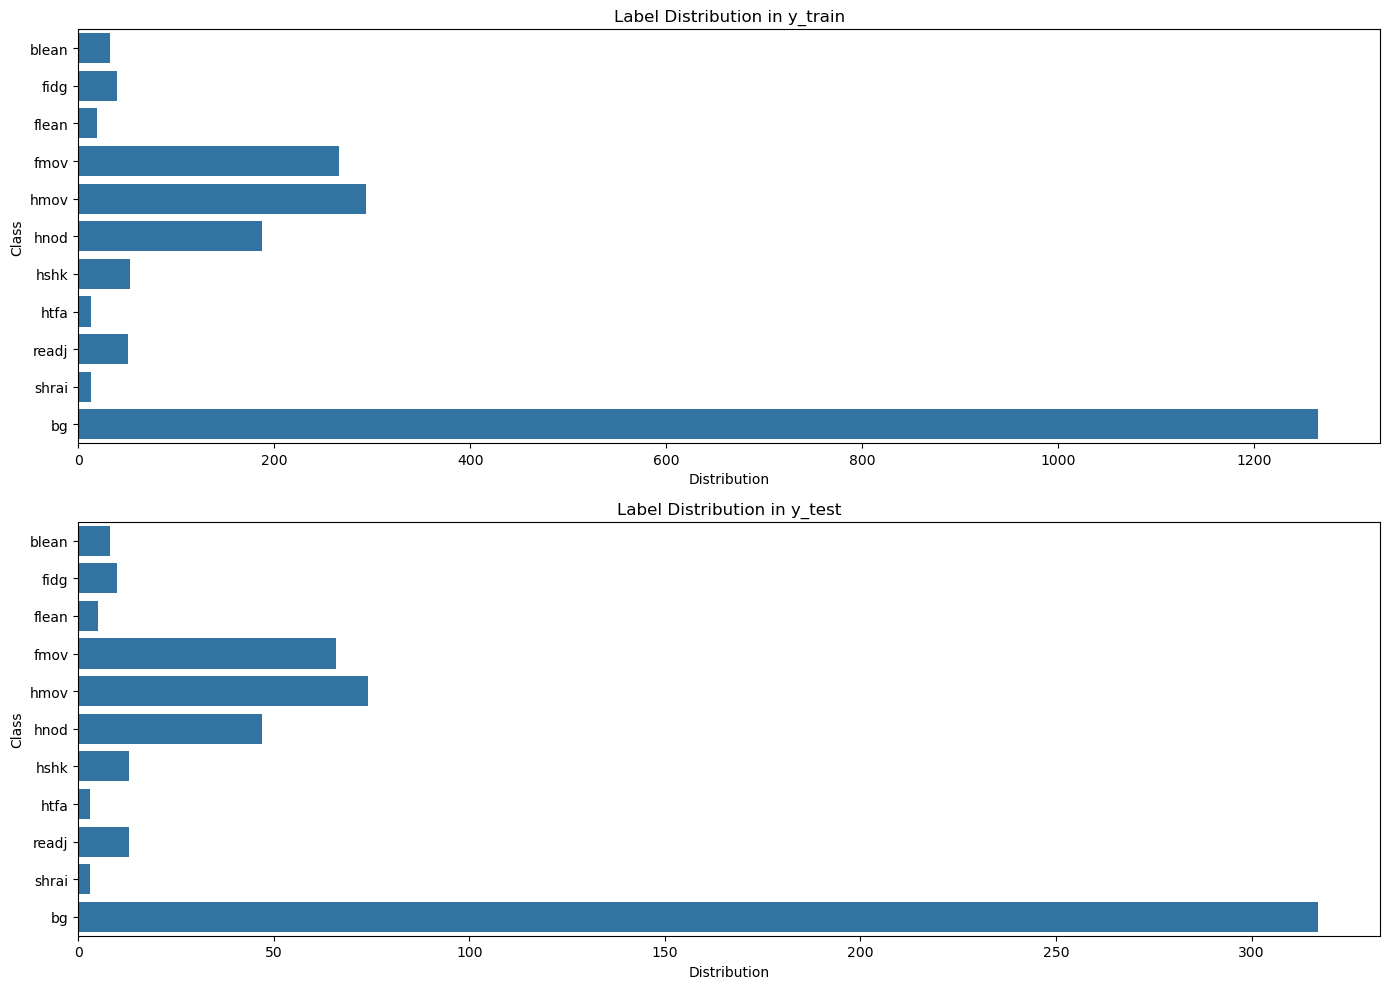

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming y_train and y_test are binary/multilabel matrices
# and feature_names is a list of class names in the same order

# Sum the labels for each class to get the distribution
train_class_distribution = y_train.sum(axis=0)
test_class_distribution = y_test.sum(axis=0)

# Create a DataFrame for easy labeling
df_train = pd.DataFrame({'Class': feature_names, 'Distribution': train_class_distribution})
df_test = pd.DataFrame({'Class': feature_names, 'Distribution': test_class_distribution})

# Create bar plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))
sns.barplot(x='Distribution', y='Class', data=df_train, ax=axes[0], orient='h')
axes[0].set_title('Label Distribution in y_train')

sns.barplot(x='Distribution', y='Class', data=df_test, ax=axes[1], orient='h')
axes[1].set_title('Label Distribution in y_test')

plt.tight_layout()
plt.show()


In [ ]:
feature_names

['blean',
 'fidg',
 'flean',
 'fmov',
 'hmov',
 'hnod',
 'hshk',
 'htfa',
 'readj',
 'shrai',
 'bg']

In [285]:
# Create a DataFrame for easy labeling
df_train = pd.DataFrame({'Class': feature_names, 'Distribution': train_class_distribution})
df_test = pd.DataFrame({'Class': feature_names, 'Distribution': test_class_distribution})
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

df_dataset = pd.concat([df_test.set_index(['Class', 'dataset']), df_train.set_index(['Class', 'dataset'])])

In [286]:
df_unstack = df_dataset.unstack('dataset').droplevel(0, axis=1)
df_unstack.columns.name = None
df_unstack['total'] = df_unstack['test'] + df_unstack['train']
df_unstack


,test,train,total
Class,,,
bg,317,1265,1582
blean,8,32,40
fidg,10,40,50
flean,5,19,24
fmov,66,266,332
hmov,74,294,368
hnod,47,187,234
hshk,13,53,66
htfa,3,13,16


In [287]:
# Calculate class weights based on the distribution
class_weights = df_unstack['total'] / df_unstack['total'].sum()

# Map class names to their corresponding weights
class_weight_dict = dict(zip(feature_names, class_weights))

class_weight_df = pd.DataFrame(zip(feature_names, class_weights), columns=['class','weight'])
class_weight_df

,class,weight
0,blean,0.566619
1,fidg,0.014327
2,flean,0.017908
3,fmov,0.008596
4,hmov,0.118911
5,hnod,0.131805
6,hshk,0.083811
7,htfa,0.023639
8,readj,0.005731
9,shrai,0.022923


In [295]:
# Add a new column "dataset" with initial values set to 'train'
df_vis_move['dataset'] = 'train'

# Assign 'test' to the rows corresponding to test indices
df_vis_move.loc[test_index, 'dataset'] = 'test'

# df_vis_move.set_index(['begin','seat','view','dataset'])

dave_folder = osp.join('..','dataset_001')
df_vis_move.drop('features', axis=1).set_index(['begin','seat','view','filenames', 'dataset']).to_csv(osp.join(dave_folder,'all_data.csv'))
df_vis_move.loc[df_vis_move['dataset']=='train'].drop('features', axis=1)[['filenames']+feature_names].to_csv(osp.join(dave_folder,'train.csv'))
df_vis_move.loc[df_vis_move['dataset']=='test'].drop('features', axis=1)[['filenames']+feature_names].to_csv(osp.join(dave_folder,'test.csv'))


In [24]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt

# Step 1: Reduce dimensions using PCA
pca = PCA(n_components=50)  # Choose the number of components you want
pca_result = pca.fit_transform(features)



In [79]:
# Step 2: Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result, labels)



In [88]:
umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', n_jobs=-1, 
                       verbose=True)
# umap_result = umap_model.fit_transform(pca_result)
umap_result = umap_model.fit_transform(features)


UMAP( verbose=True)
Tue Dec 26 12:06:06 2023 Construct fuzzy simplicial set
Tue Dec 26 12:08:22 2023 Finding Nearest Neighbors
Tue Dec 26 12:08:22 2023 Finished Nearest Neighbor Search
Tue Dec 26 12:08:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 26 12:08:26 2023 Finished embedding


In [81]:
n_labels

5

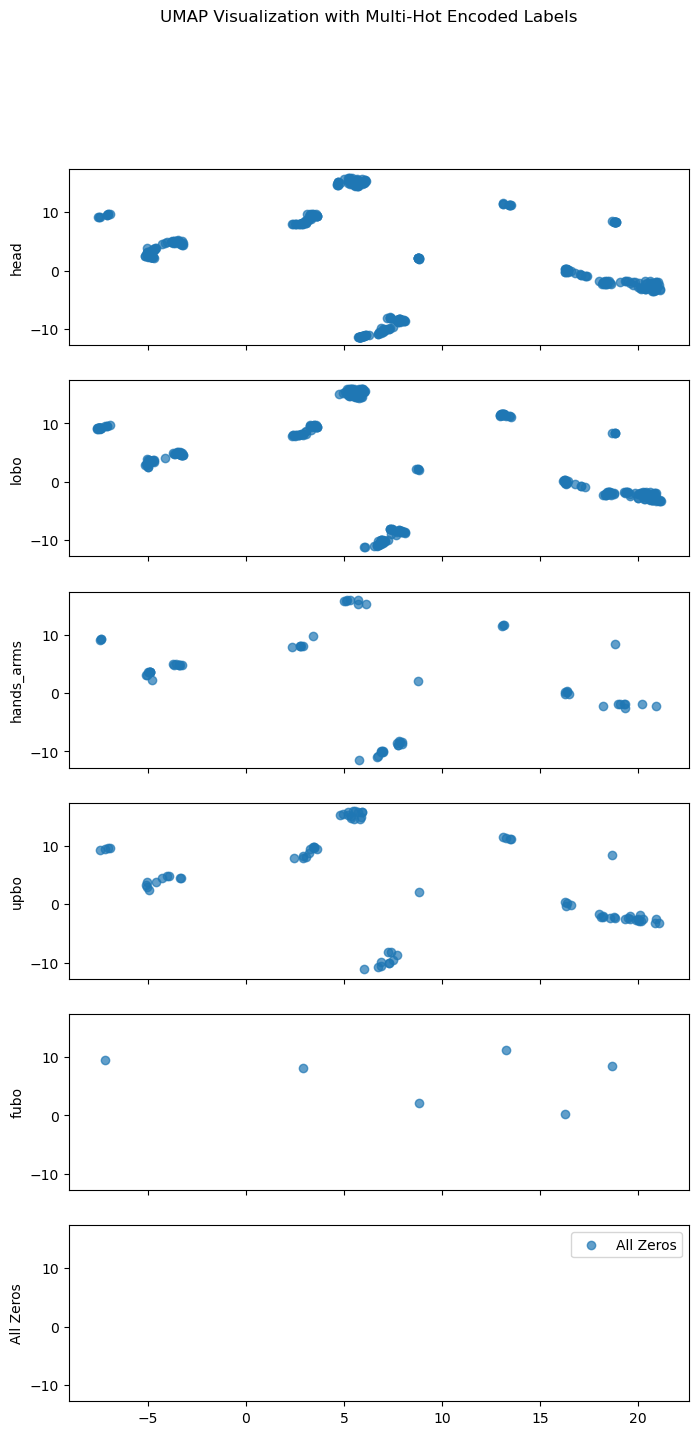

In [89]:


reduced = umap_result
# reduced = tsne_result
names = tier_names
n_labels = len(names)

# Create subplots for each feature
fig, axs = plt.subplots(n_labels+1, 1, figsize=(8, 16), sharex=True, sharey=True)


# Plot points when the value is one for each feature
for label_dim in range(n_labels):
    label_points = reduced[labels[:, label_dim] == 1]
    feature_name = names[label_dim]
    axs[label_dim].scatter(label_points[:, 0], label_points[:, 1], label=f'{feature_name}', alpha=0.7)
    axs[label_dim].set_ylabel(f'{feature_name}')

# Add another subplot for when all values are zeros
all_zeros_points = reduced[np.all(labels == 0, axis=1)]
axs[-1].scatter(all_zeros_points[:, 0], all_zeros_points[:, 1], label='All Zeros', alpha=0.7)
axs[-1].set_ylabel('All Zeros')

# Add legend to the last subplot
axs[-1].legend()

# plt.suptitle('t-SNE Visualization with Multi-Hot Encoded Labels')
plt.suptitle('UMAP Visualization with Multi-Hot Encoded Labels')
plt.show()

In [106]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a multi-label SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)
multi_label_svm = MultiOutputClassifier(svm_classifier)

# Train the multi-label SVM classifier
multi_label_svm.fit(X_train, y_train)

# Make predictions on the test set
predictions = multi_label_svm.predict(X_test)

# Evaluate the performance (accuracy in this example)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
